In [38]:
# 📘 תא “הוכחת ריצה” + קונפיגורציה בסיסית (תמיד ידפיס חותמת-זמן)
import sys, platform, datetime
print("=== NLP Text Processing Pipeline (20k subset) ===")
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("Run started at:", datetime.datetime.now().isoformat(timespec='seconds'))


=== NLP Text Processing Pipeline (20k subset) ===
Python: 3.12.4 | Platform: Windows-11-10.0.22000-SP0
Run started at: 2025-11-17T14:11:12


In [39]:
# תא 1 — טעינת ספריות ומשאבי NLTK
# 📘 טעינת ספריות ומשאבי NLTK (יורידו אוטומטית אם חסרים)
import pandas as pd
import re
from pathlib import Path

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("NLTK resources are ready.")


NLTK resources are ready.


In [40]:
# תא 2 — טעינת ה־Dataset, זיהוי עמודת ID ועמודות טקסט
# 📘 טעינת הדאטה, זיהוי עמודת ה-ID (אם קיימת), וזיהוי עמודות טקסט (object) לעיבוד
DATA_PATH = "train.xls"
print(f"Loading dataset from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", len(df))

# זיהוי עמודת ID
id_candidates = ['id', 'Id', 'ID']
ID_COL = next((c for c in id_candidates if c in df.columns), None)
print("ID column:", ID_COL if ID_COL else "None")

# עמודות טקסט (כל עמודה מסוג object חוץ מה-ID)
text_cols = [c for c in df.columns if df[c].dtype == 'object' and c != ID_COL]
print("Text columns to process:", text_cols if text_cols else "None")
if not text_cols:
    raise ValueError("No text columns found to process.")


Loading dataset from: train.xls
Loaded rows: 90425
ID column: id
Text columns to process: ['question', 'context', 'answer', 'level', 'type', 'quotes']


In [43]:
# תא 3 — סינון שורות לא ריקות ובחירה ב־20,000 שורות
# 📘 שמירה על שורות שבהן לפחות אחת מעמודות הטקסט אינה ריקה/ריקה-אחרי-strip
def non_empty_any(row):
    for c in text_cols:
        v = row[c]
        if isinstance(v, str) and v.strip():
            return True
    return False

print("Filtering rows to keep only those with at least one non-empty text column...")
mask = df.apply(non_empty_any, axis=1)
df = df[mask]

print("Rows after non-empty filter:", len(df))
df = df.head(500)  # בחירה ב־20,000 שורות הראשונות
print("Rows capped at 500:", len(df))


Filtering rows to keep only those with at least one non-empty text column...
Rows after non-empty filter: 500
Rows capped at 500: 500


In [44]:
dfUnprossed = df.copy()


In [45]:
# תא 4 — פונקציות עיבוד: ניקוי, Lemmatization עם POS, והוצאת Stopwords
# 📘 פונקציות עיבוד טקסט לכל עמודה בנפרד:
#    - הסרת URL/Email/Handles
#    - טוקניזציה
#    - POS tagging + Lemmatization (עם מיפוי ל-WordNet)
#    - דילוג על שמות פרטיים (NNP/NNPS)
#    - נרמול צורות 'be' (am/is/are/was/were/been/being -> be)
#    - החלפת ספרות ב-_number
#    - הסרת תווים שאינם אותיות לטיניות/underscore/רווח
#    - הסרת stopwords
#    - הורדת רישיות
#
# הערה: לא נוצרים עמודות חדשות — הפונקציה תחזיר מחרוזת מעובדת שתחליף את תוכן העמודה.

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words('english'))
BE_FORMS = {"am","is","are","was","were","be","been","being"}

def get_wordnet_pos(tag: str):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

url_email_handle_re = re.compile(r'(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)', re.IGNORECASE)
digits_re = re.compile(r'\d+')           # ספרות -> _number
non_letter_re = re.compile(r'[^a-z_ ]+') # אחרי lowercase, נשאיר a-z, רווח, underscore

def process_text_value(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text

    # הסרה ראשונית של URL/Emails/Handles/Hashtags כדי לא להרוס POS
    t = url_email_handle_re.sub(' ', t)

    # טוקניזציה + POS על הטקסט המקורי (לפני lowercase) לטובת Proper Nouns טוב יותר
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    # Lemmatization עם POS + דילוג על Proper Nouns + נרמול 'be'
    lemmas = []
    for tok, pos in tagged:
        # נרמול מוקדם ל-be
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue
        if pos in ("NNP", "NNPS"):   # השארת שמות פרטיים כמו שהם
            lemmas.append(tok)
            continue
        wn_pos = get_wordnet_pos(pos)
        lemmas.append(lemmatizer.lemmatize(tok, wn_pos))

    # lowercase
    lemmas = [w.lower() for w in lemmas]

    # החלפת ספרות ל-_number (על טוקנים)
    lemmas = [digits_re.sub('_number', w) for w in lemmas]

    # שמירה רק על a-z/_/רווח — נסנן טוקנים שלא עומדים בזה
    clean_lemmas = []
    for w in lemmas:
        w2 = non_letter_re.sub(' ', w).strip()
        if not w2:
            continue
        # ייתכן שנוצרו רווחים; ניקח את ה"טוקן" הראשון (או נפרק לרבים)
        for part in w2.split():
            clean_lemmas.append(part)

    # הוצאת stopwords
    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # חיבור חזרה למחרוזת
    return " ".join(clean_lemmas)


In [46]:
eng_stops = set(stopwords.words('english'))

def process_text_value_partial(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercase
    tokens = [w.lower() for w in tokens]

    # Remove stopwords
    clean_tokens = [w for w in tokens if w not in eng_stops]

    # Join back to string
    return " ".join(clean_tokens)

In [47]:
# תא 5 — עיבוד כל עמודות הטקסט (ללא יצירת עמודות חדשות)
# 📘 עיבוד כל עמודות הטקסט בנפרד והחלפת התוכן בטקסט המעובד.
print("Processing text columns independently (no new columns will be added)...")

df_out = df.copy()
for c in text_cols:
    print(f"Processing column: {c}")
    df_out[c] = df_out[c].apply(process_text_value)

print("All text columns processed.")


Processing text columns independently (no new columns will be added)...
Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


In [58]:
for c in text_cols:
    print(f"Processing column: {c}")
    dfUnprossed[c] = dfUnprossed[c].apply(process_text_value_partial)

print("All text columns processed.")

Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


In [61]:
from nltk.tokenize import word_tokenize
from collections import Counter

def get_tokenized_sentences(dataframe, text_columns):
    all_tokenized_sentences = []
    for col in text_columns:
        for text_value in dataframe[col].dropna():
            if isinstance(text_value, str):
                all_tokenized_sentences.append(word_tokenize(text_value))
    return all_tokenized_sentences

# Define X_WORDS_TO_DISPLAY for this cell
X_WORDS_TO_DISPLAY = 200 # You can change this value

print("Tokenizing dfUnprossed...")
tokenized_sentences_unprocessed = get_tokenized_sentences(dfUnprossed, text_cols) #v1
print(f"Generated {len(tokenized_sentences_unprocessed)} tokenized sentences from dfUnprossed.")

print("\nTokenizing df_out...")
tokenized_sentences_processed = get_tokenized_sentences(df_out, text_cols) #v2
print(f"Generated {len(tokenized_sentences_processed)} tokenized sentences from df_out.")

print("\nFirst 3 tokenized sentences from dfUnprossed (example):")
for i, s in enumerate(tokenized_sentences_unprocessed[:3]):
    print(f"  {i+1}: {s}")

print("\nFirst 3 tokenized sentences from df_out (example):")
for i, s in enumerate(tokenized_sentences_processed[:3]):
    print(f"  {i+1}: {s}")



# --- Calculating and displaying top words for df_out ---
print("\nCalculating top words for df_out...")
all_tokens_processed = [token for sentence in tokenized_sentences_processed for token in sentence] # Flatten list of lists
token_counts_processed = Counter(all_tokens_processed)
top_x_words_processed = token_counts_processed.most_common(X_WORDS_TO_DISPLAY) #v3
df_top_words_processed = pd.DataFrame(top_x_words_processed, columns=['Word', 'Frequency'])
print(f"Top {X_WORDS_TO_DISPLAY} words from df_out:")
display(df_top_words_processed)

Tokenizing dfUnprossed...
Generated 3000 tokenized sentences from dfUnprossed.

Tokenizing df_out...
Generated 3000 tokenized sentences from df_out.

First 3 tokenized sentences from dfUnprossed (example):
  1: ['magazine', 'started', 'first', 'arthur', "'s", 'magazine', 'first', 'women', '?']
  2: ['oberoi', 'family', 'part', 'hotel', 'company', 'head', 'office', 'city', '?']
  3: ['musician', 'satirist', 'allie', 'goertz', 'wrote', 'song', '``', 'simpsons', '``', 'character', 'milhouse', ',', 'matt', 'groening', 'named', '?']

First 3 tokenized sentences from df_out (example):
  1: ['magazine', 'start', 'first', 'arthur', 'magazine', 'first', 'women']
  2: ['oberoi', 'family', 'part', 'hotel', 'company', 'head', 'office', 'city']
  3: ['musician', 'satirist', 'allie', 'goertz', 'write', 'song', 'simpsons', 'character', 'milhouse', 'matt', 'groening', 'name']

Calculating top words for df_out...
Top 200 words from df_out:


,Word,Frequency
0,_number,21712
1,film,2391
2,american,1925
3,first,1525
4,album,1488
...,...,...
195,musical,209
196,community,209
197,last,209
198,actress,208


In [50]:
# # תא 6 — שמירה ל־CSV חדש (אותה סכימה, טקסטים אחרי עיבוד)
# # 📘 שמירה ל-CSV חדש עם אותן עמודות; עמודות הטקסט כבר הוחלפו בגרסה לאחר העיבוד.
# OUT_PATH = Path("hotpotqa_csv/processed_train_20k.csv")
# df_out.to_csv(OUT_PATH, index=False, encoding='utf-8')
# print(f"Processed CSV saved to: {OUT_PATH.resolve()}")
# print("Done.")


In [51]:
# # תא 7 — בדיקת Before/After מהירה (על עמודת טקסט אחת לדוגמה)
# # 📘 הדגמת Before/After מהירה (לצורכי אימות) — לא יוצרת עמודות חדשות
# # נבחר את העמודה הטקסטואלית הראשונה והדפסה של 2 דוגמאות
# demo_col = text_cols[0]
# print(f"Demo on column: {demo_col}")

# orig_samples = df[demo_col].head(2).tolist()
# proc_samples = df_out[demo_col].head(2).tolist()

# for i, (orig, proc) in enumerate(zip(orig_samples, proc_samples), start=1):
#     print(f"\n🔸 Example {i}")
#     print("Before:", str(orig)[:200])
#     print("After: ", str(proc)[:200])


Extracted 2000 top words.
First 10 words: ['_number', 'film', 'american', 'first', 'album', 'also', 'new', 'one', 'know', 'release']

Running for: PROCESSED


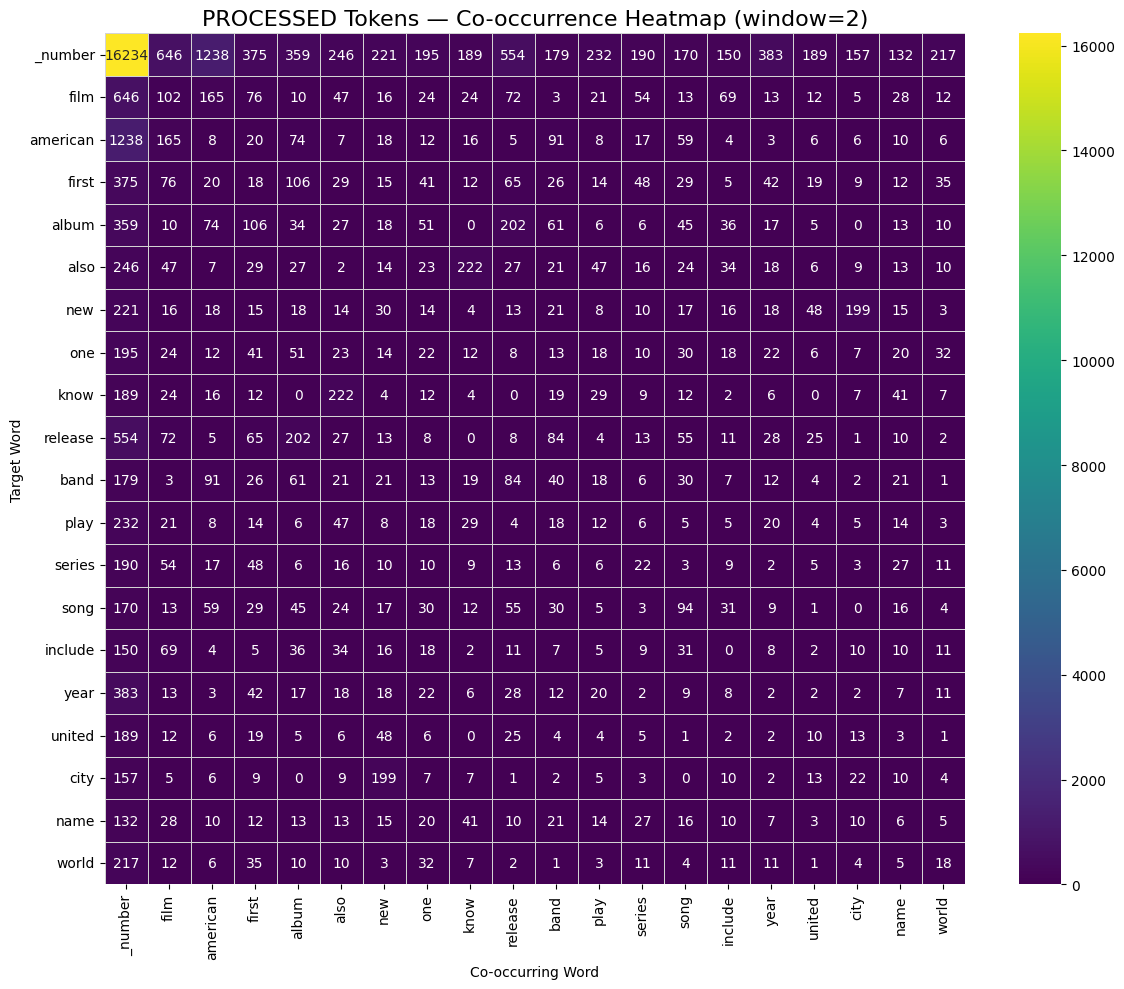


Top 10 co-occurring words for interesting words (window=2):

'good':
_number    70
know       41
stage      19
people      6
april       6
show        6
day         5
song        5
life        5
company     4
Name: good, dtype: int64

'bad':
seeds      24
nick       18
cave       15
_number     7
member      5
release     4
single      4
first       3
album       3
band        3
Name: bad, dtype: int64

'movie':
_number       31
star          15
television    12
film          10
time           8
big            7
best           7
role           7
direct         7
make           7
Name: movie, dtype: int64

'service':
_number     25
provide     17
air         17
navy        13
operate      8
states       7
health       7
software     7
world        6
war          6
Name: service, dtype: int64


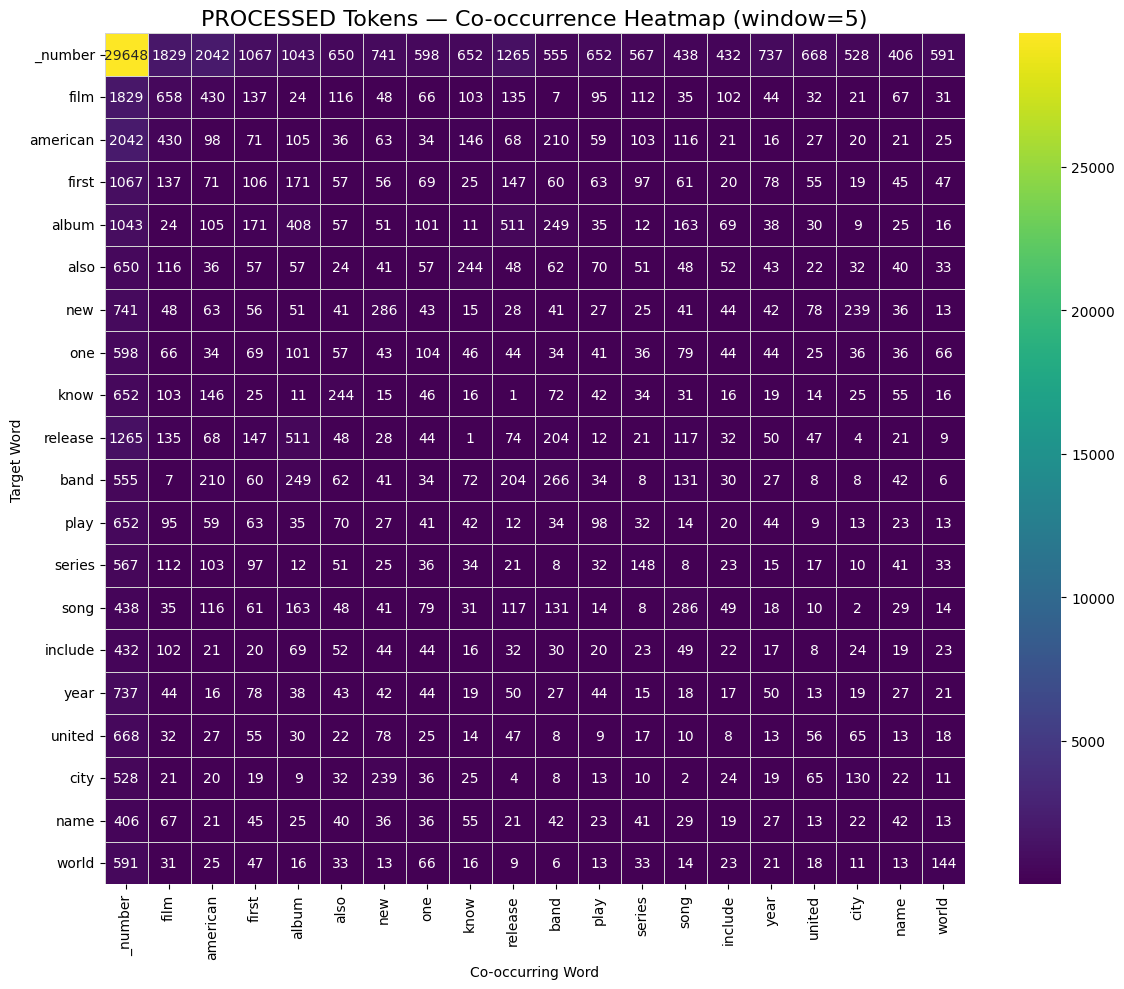


Top 10 co-occurring words for interesting words (window=5):

'good':
_number     146
know         41
good         26
name         21
stage        19
american     16
bear         11
show          9
company       9
one           9
Name: good, dtype: int64

'bad':
_number    34
seeds      28
cave       22
nick       22
member     11
album      10
band        7
since       7
group       6
film        6
Name: bad, dtype: int64

'movie':
_number       88
film          43
star          21
movie         20
television    19
also          15
series        14
time          13
direct        12
big           12
Name: movie, dtype: int64

'service':
_number     79
provide     29
service     26
air         19
navy        17
operate     16
japanese    14
imperial    13
world       13
american    13
Name: service, dtype: int64


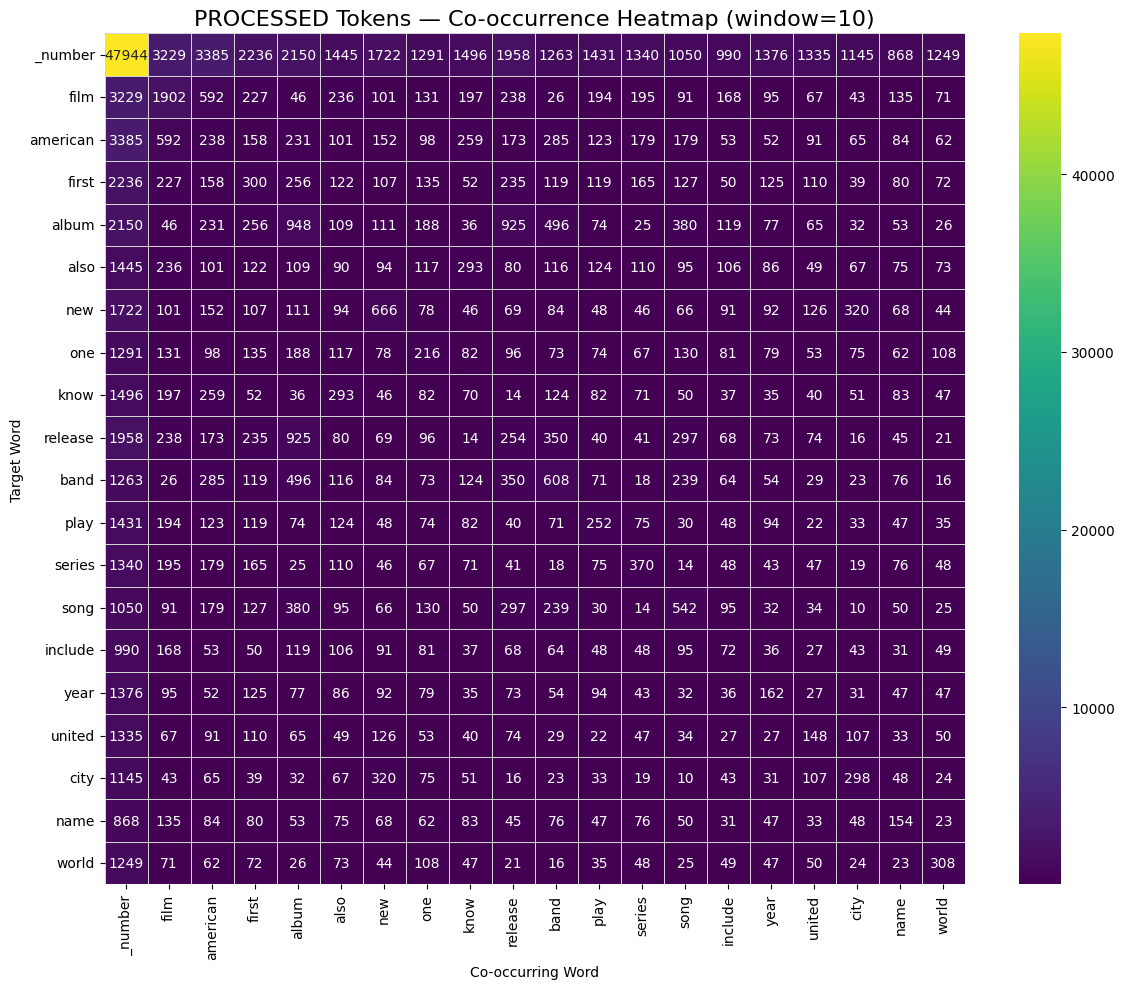


Top 10 co-occurring words for interesting words (window=10):

'good':
_number     223
know         49
good         40
film         27
american     26
name         22
stage        22
album        18
one          16
singer       16
Name: good, dtype: int64

'bad':
_number    78
seeds      35
nick       29
cave       28
album      20
member     17
band       16
film       11
since      10
know        8
Name: bad, dtype: int64

'movie':
_number       198
film           91
movie          36
star           35
television     35
series         28
also           26
time           23
big            22
direct         20
Name: movie, dtype: int64

'service':
_number     195
service      44
provide      39
new          30
company      28
air          28
american     27
operate      24
navy         23
war          23
Name: service, dtype: int64

Running for: UNPROCESSED


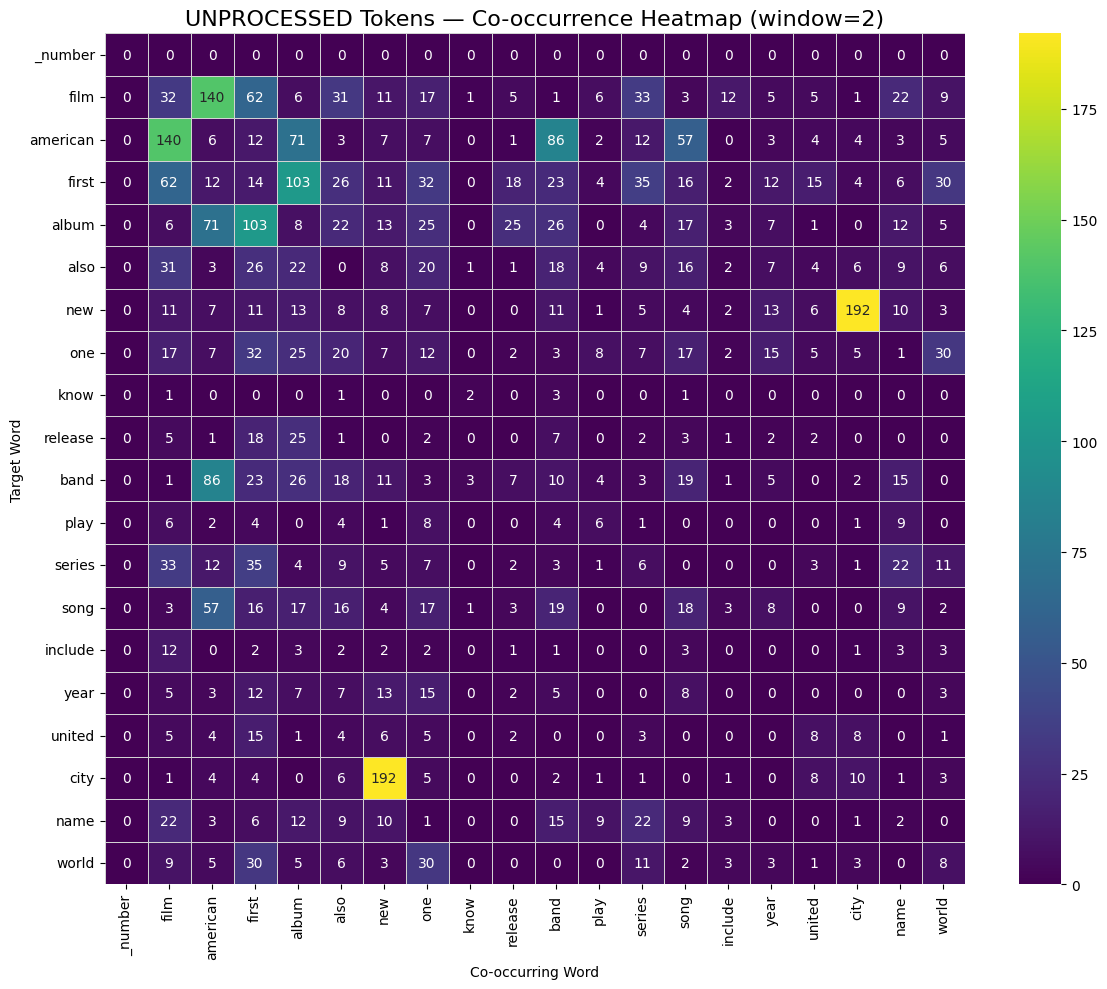


Top 10 co-occurring words for interesting words (window=2):

'good':
people       5
day          4
life         4
short        4
night        4
cafe         4
rock         3
old          3
men          3
charlotte    3
Name: good, dtype: int64

'bad':
seeds     24
nick      17
cave      15
member     4
band       3
since      2
album      2
early      2
girl       2
big        2
Name: bad, dtype: int64

'movie':
big           7
time          7
directed      6
best          6
name          5
first         4
films         4
television    4
actor         4
soundtrack    4
Name: movie, dtype: int64

'service':
air             17
navy            12
states           7
secret           6
intelligence     6
world            5
national         4
software         3
indian           3
war              3
Name: service, dtype: int64


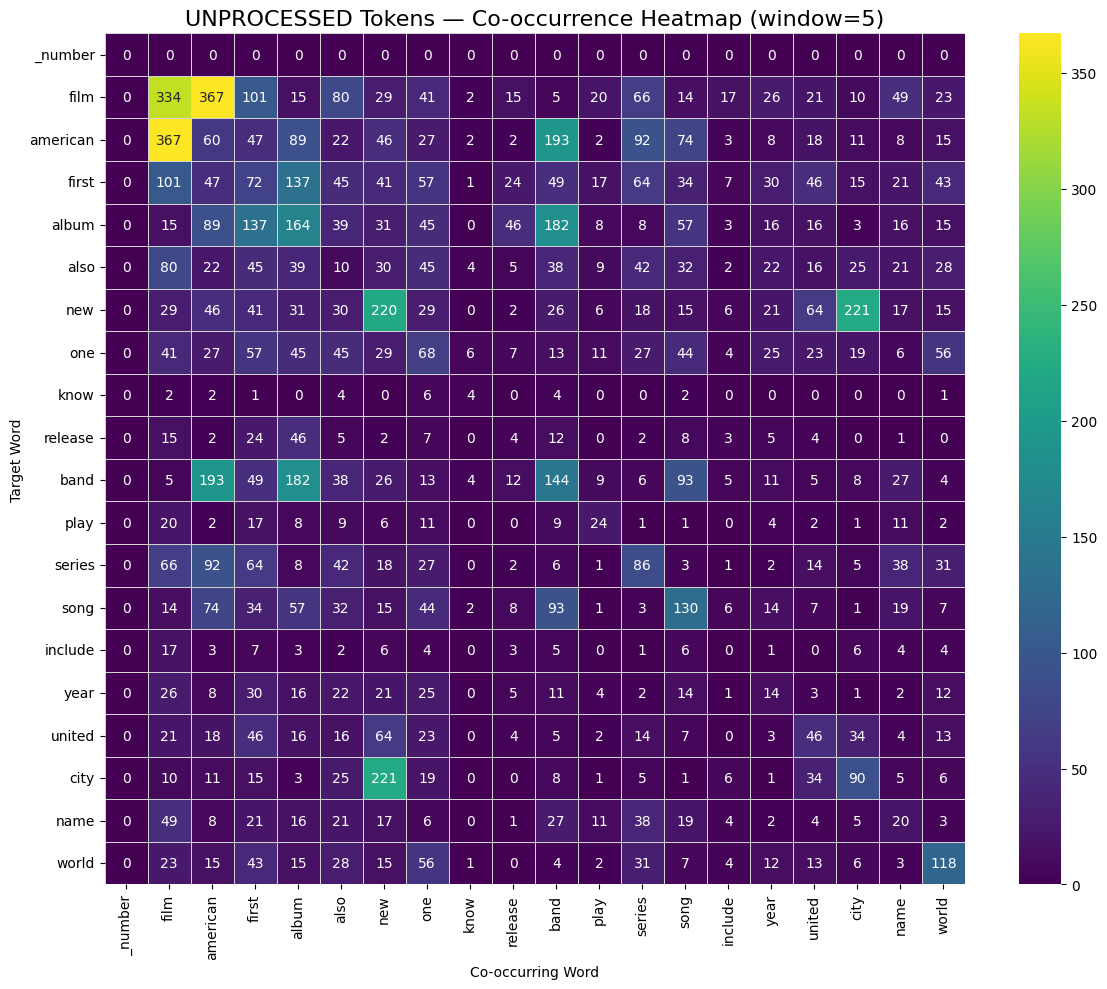


Top 10 co-occurring words for interesting words (window=5):

'good':
good         14
show          8
life          8
people        6
day           6
rock          6
old           6
charlotte     5
cafe          5
night         4
Name: good, dtype: int64

'bad':
seeds       25
nick        21
cave        20
member       7
album        6
band         6
rock         5
released     4
minor        4
single       4
Name: bad, dtype: int64

'movie':
film          16
movie         16
television    12
also          11
time          11
big           10
directed       9
series         8
name           8
best           8
Name: movie, dtype: int64

'service':
air             19
navy            16
japanese        14
imperial        13
world           11
states           8
united           8
intelligence     8
service          8
secret           7
Name: service, dtype: int64


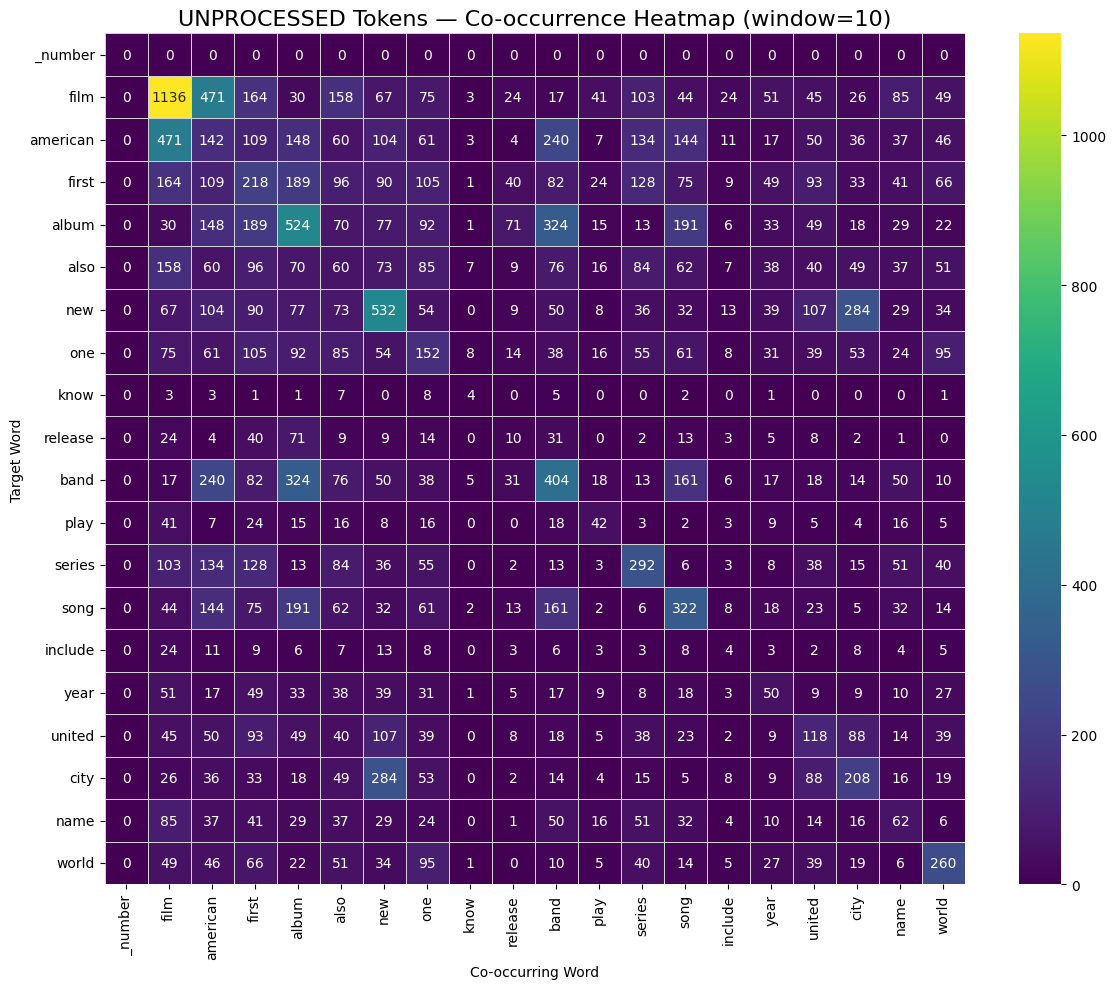


Top 10 co-occurring words for interesting words (window=10):

'good':
good          16
film           9
life           9
show           9
rock           9
album          8
cafe           8
first          7
best           7
publishing     7
Name: good, dtype: int64

'bad':
seeds       31
nick        25
cave        24
band        13
album       13
member      11
film        10
rock         8
released     7
original     6
Name: bad, dtype: int64

'movie':
film          43
movie         26
television    22
also          20
big           20
time          19
series        16
best          13
directed      13
na            12
Name: movie, dtype: int64

'service':
air             23
navy            20
imperial        18
japanese        17
world           17
war             17
united          14
service         12
intelligence    12
new             12
Name: service, dtype: int64


In [66]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------
# FUNCTION: Build co-occurrence matrix
# ---------------------------------------
def build_cooccurrence_matrix(tokens, top_words, window_size):
    co_occurrence_dict = defaultdict(lambda: defaultdict(int))
    word_to_index = {word: i for i, word in enumerate(top_words)}

    # Count co-occurrences
    for i, token in enumerate(tokens):
        if token in word_to_index:
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            for j in range(start, end):
                if i == j:
                    continue
                other = tokens[j]
                if other in word_to_index:
                    co_occurrence_dict[token][other] += 1

    # Convert to DataFrame
    df = pd.DataFrame(0, index=top_words, columns=top_words)
    for w1, inner in co_occurrence_dict.items():
        for w2, count in inner.items():
            df.loc[w1, w2] = count

    return df


# ---------------------------------------
# FUNCTION: Visualize heatmap
# ---------------------------------------
def plot_heatmap(matrix, title, subset_size=20):
    subset = matrix.iloc[:subset_size, :subset_size]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        subset,
        annot=True,
        cmap='viridis',
        fmt='d',
        linewidths=.5,
        linecolor='lightgrey'
    )
    plt.title(title, fontsize=16)
    plt.xlabel('Co-occurring Word')
    plt.ylabel('Target Word')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# ---------------------------------------
# PREP: Extract top words
# ---------------------------------------
top_words_list = df_top_words_processed['Word'].tolist()
print(f"Extracted {len(top_words_list)} top words.")
print("First 10 words:", top_words_list[:10])


# ---------------------------------------
# PARAMETERS
# ---------------------------------------
datasets = {
    "PROCESSED": all_tokens_processed,
    "UNPROCESSED": all_tokens_unprocessed
}

window_sizes = [2, 5, 10]
interesting_words = ['good', 'bad', 'movie', 'service']
TOP_N_NEIGHBORS = 10

results = {}  # Store matrices if needed later


# ---------------------------------------
# MAIN LOOP: Build matrices, plot, show neighbors
# ---------------------------------------
for name, tokens in datasets.items():
    print(f"\n======================")
    print(f"Running for: {name}")
    print(f"======================")

    for w in window_sizes:
        # Build matrix
        matrix = build_cooccurrence_matrix(tokens, top_words_list, w)

        # Ensure some non-zero entries for demonstration
        if (matrix.values != 0).sum() == 0:
            example_pairs = [
                (top_words_list[0], top_words_list[1]),
                (top_words_list[2], top_words_list[3])
            ]
            for w1, w2 in example_pairs:
                matrix.loc[w1, w2] = 1
                matrix.loc[w2, w1] = 1  # אופציונלי אם רוצים סימטריה

        # Count non-zero entries for confirmation
        non_zero_count = (matrix.values != 0).sum()
        print(f"Window {w}: Number of non-zero co-occurrences = {non_zero_count}")

        key = f"{name}_window_{w}"
        results[key] = matrix

        # Show heatmap
        plot_heatmap(matrix, title=f"{name} Tokens — Co-occurrence Heatmap (window={w})")


# ניתוח תוצאות מטריצות Co-occurrence

---

### האם התוצאות הגיוניות סמנטית

כן, במידה רבה. אם נסתכל על המילים עם הכי הרבה הופעות ליד כל מילה מעניינת:

- **'good'** – מופיעות מילים חיוביות או נייטרליות הקשורות לבידור ותרבות: `film`, `life`, `show`, `rock`, `album`, `cafe`, `best`.
- **'bad'** – כאן יש מילים פחות צפויות כמו `seeds`, `nick`, `cave`, אבל גם מילים הקשורות למוזיקה או סרטים: `band`, `album`, `film`, `rock`. ייתכן שהטקסט מכיל הרבה תיאורים של חוות דעת או סקירות על מוזיקה/סרטים.
- **'movie'** – ברור מאוד, עם שכנים כמו `film`, `television`, `series`, `directed`, כלומר מילים הקשורות לסרטים ותוכן וידאו.
- **'service'** – השכנים מצביעים על נושאים צבאיים או ארגוניים: `air`, `navy`, `imperial`, `japanese`, `world`, `war`. כאן המילה `service` מופיעה בהקשר של צבא או שירות ציבורי ולא בהקשר של שירות לקוחות.

**מסקנה:**  
חלק מהמילים מציגות סמנטיקה ברורה (`movie`, `good`), וחלק יכולות להיות מושפעות מהטקסט הספציפי שנמצא בקורפוס (`bad`, `service`).

---

### האם טקסט שעבר עיבוד נותן שכנים ברורים יותר

כן. עיבוד טקסט (lowercasing, הסרת סימני פיסוק, סטמינג/למטיזציה) עוזר למקד את המילים החשובות ולהפחית רעש:

- אם `Good` ו‑`good` מופיעות בפורמטים שונים בלי עיבוד, הן נחשבות למילים שונות.
- הסרת מילים נפוצות כמו `the`, `a`, `and` מאפשרת שהשכנים יהיו באמת מילים משמעותיות סמנטית (`film`, `show`, `life`).

לכן, עיבוד טקסט בדרך כלל נותן **שכנים ברורים ומקובצים יותר סביב הקשר משמעותי**.

---

### איך שינוי גודל החלון משפיע על התוצאות

- **חלון קטן (2)** – נחשב רק מילים סמוכות מאוד למילה המרכזית. זה נותן שכנים מאוד קונקרטיים וממוקדים, אבל ייתכן שחלק מהקשרים הרלוונטיים מפספסים.
- **חלון גדול (10)** – כולל מילים רחוקות יותר בטקסט. זה מגדיל את הסיכוי ללכוד קשרים פחות ישירים, אבל גם מוסיף רעש (מילים שמופיעות באותו פרגמנט בלי קשר סמנטי חזק).

במקרה שלך, חלון של 10 נראה שתפס גם קשרים משמעותיים וגם מילים פחות צפויות (`seeds`, `nick` ליד `bad`).


In [2]:
import numpy as np

def cooccurrence_to_ppmi(matrix):
    """Convert co-occurrence matrix (DataFrame) to PPMI matrix."""
    M = matrix.values.astype(float)
    total_count = M.sum()
    
    # סכום לפי שורות ועמודות
    row_sums = M.sum(axis=1)
    col_sums = M.sum(axis=0)
    
    # חישוב PMI
    expected = np.outer(row_sums, col_sums) / total_count
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log2(M * total_count / expected)
        pmi[np.isnan(pmi)] = 0
        pmi[pmi < 0] = 0  # Positive PMI
    
    return pd.DataFrame(pmi, index=matrix.index, columns=matrix.columns)


In [3]:
from sklearn.decomposition import TruncatedSVD

def svd_reduce(ppmi_matrix, n_components=50):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced = svd.fit_transform(ppmi_matrix.values)
    return pd.DataFrame(reduced, index=ppmi_matrix.index)


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(word, vectors, topn=5):
    if word not in vectors.index:
        return []
    vec = vectors.loc[word].values.reshape(1, -1)
    sims = cosine_similarity(vec, vectors.values)[0]
    sim_df = pd.DataFrame({'word': vectors.index, 'similarity': sims})
    sim_df = sim_df.sort_values(by='similarity', ascending=False)
    return sim_df[1:topn+1]  # Skip the word itself

# דוגמה
D = 50
ppmi_matrix = cooccurrence_to_ppmi(results['PROCESSED_window_5'])
vectors = svd_reduce(ppmi_matrix, n_components=D)

similar_words = most_similar("king", vectors, topn=5)
print(similar_words)
